# Methodology - Temperature Experiment


$\bullet$ A naïve baseline will be created.

$\bullet$ A LSTM NN will be trained using temperature data and pruned using the proposed methodology in the research.

In [1]:
#Setting conditions for the data beforehand
INITIAL_DATA = 120  #How many data points used as inputs
PRED_DATA    = 15   #How many data points used as outputs
SPLITTER     = 95/100 #How much data is attributed to training and how much to tesitng on
BATCH        = 44  #How big is the training batch

### Naïve Baseline

In [2]:
from thesis_functions_redux import *
%matplotlib inline

def naive(INITIAL_DATA,
          PRED_DATA,
          SPLITTER,
          BATCH):
    """
                                                Description:
    --------------------------------------------------------------------------------------------------------------
    This is a modification of the experimental function that is utilized later. Here initial settings are chosen in
    order to get a baseline with a naïve method, before training of the final LSTM NN is done.
    --------------------------------------------------------------------------------------------------------------
    
                                              Input Parameters:
    --------------------------------------------------------------------------------------------------------------
    > INITIAL_DATA = amount of data you want to use for predicting something;
    > PRED_DATA    = amount of data you want to predict;
    > SPLITTER     = how much data will go into training and how much into testing;
    > BATCH        = how big will be the training batch;
    --------------------------------------------------------------------------------------------------------------
    
                                                   Output:
    --------------------------------------------------------------------------------------------------------------
    None
    --------------------------------------------------------------------------------------------------------------"""
    # Prepare the Temperature data for Beijing
    #---------------------------------------------
    #Temperature dataset will be loaded and visualized, but here it's done manually
    import pandas as pd
    import matplotlib.pyplot as plt
    full_data = pd.read_csv("bitcoin_exp.csv").to_numpy()
    #We will want to save the figure straight away
    f = plt.figure(figsize=(8, 6), dpi=80)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.plot(full_data)
    plt.xlabel("Time in minutes")
    plt.ylabel("BitCoin Deviations")
    plt.title("BitCoin Average Price Fluctuations Per Minute")
    f.savefig("BitCoin_generated.pdf", bbox_inches='tight')
    plt.show()
    plt.close(f)
    
    
#     Automatic generation of sin/cos data is redacted, but the variables are still retained   
#     full_data = wave(instances = INSTANCES,
#                      duration = DURATION,
#                      add_err = ADD_ERR,
#                      wave_type = "sin",
#                      show = True,
#                      save_fig = True)

    # Scale the data; it is best to do this not via functions
    #--------------------------------------------------------------------------------------------
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    full_data = scaler.fit_transform(full_data.reshape(-1, 1))
    full_data = full_data.reshape(1, -1)[0]
    # full_data = scaler.inverse_transform(full_data) # To turn data back to it's original size

    # Split the data
    #--------------------------------------------------------------------------------------------
    x_training, y_training, x_testing, y_testing = window_slider(data = full_data,
                                                                 initial_data = INITIAL_DATA,
                                                                 pred_data = PRED_DATA,
                                                                 splitter = SPLITTER,
                                                                 prepare_log = True,
                                                                 integrity = True,
                                                                 save_fig = False) 
    
    # Make a baseline data set to which efficiency of the model will be held up to
    #--------------------------------------------------------------------------------------------
    pred_baseline, true_values = baseline(true_dataset = x_testing, 
                                          true_labels = y_testing) 
    
    
    # Rescale our data back to what we would want to have (for baseline)
    #---------------------------------------------------------------------------------------------------
    import numpy as np
    BASE_FINAL_PREDICTIONS = scaler.inverse_transform(np.array(pred_baseline).reshape(-1, 1)).reshape(1, -1)[0]
    BASE_FINAL_REALITY     = scaler.inverse_transform(np.array(true_values).reshape(-1, 1)).reshape(1, -1)[0]

    # Check the accuracy of the naïve method
    #---------------------------------------------------------------------------------------------------
    accuracy_check(predictions = BASE_FINAL_PREDICTIONS,
                   reality = BASE_FINAL_REALITY,
                   model = None,
                   mse = True,
                   mae = True,
                   rmse = True,
                   visualize = True,
                   save_fig = True,
                   logger = True,
                   txt_logger = True,
                   baseline = True)

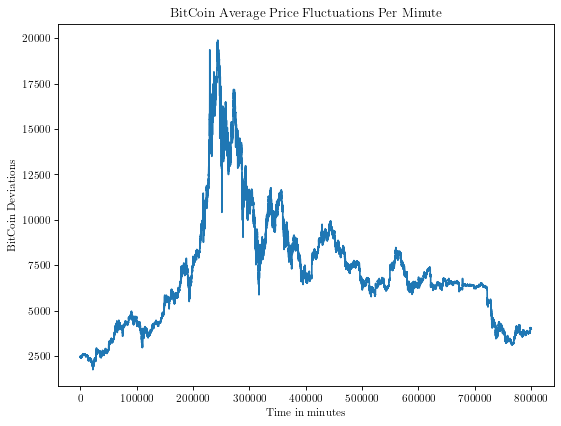

--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(760364, 120)
	Training targets have the following shape: 	(760364, 15)

	Testing data has the following shape: 		(2668, 120)
	Testing targets have the following shape: 	(2668, 15)
----------------------------------------------------------------------


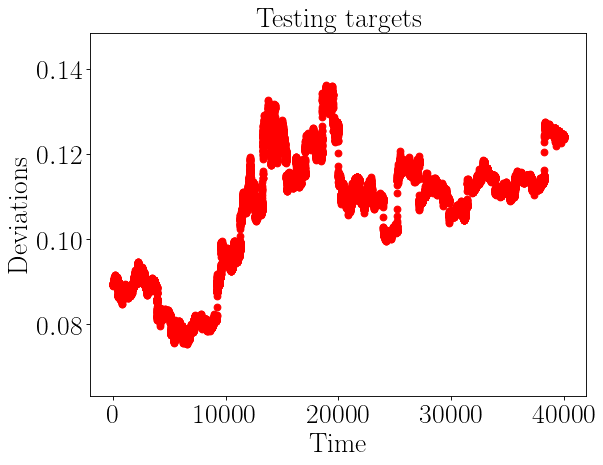

The mse score is: 853.5828
The mae score is: 16.3908
The rmse score is: 29.2161


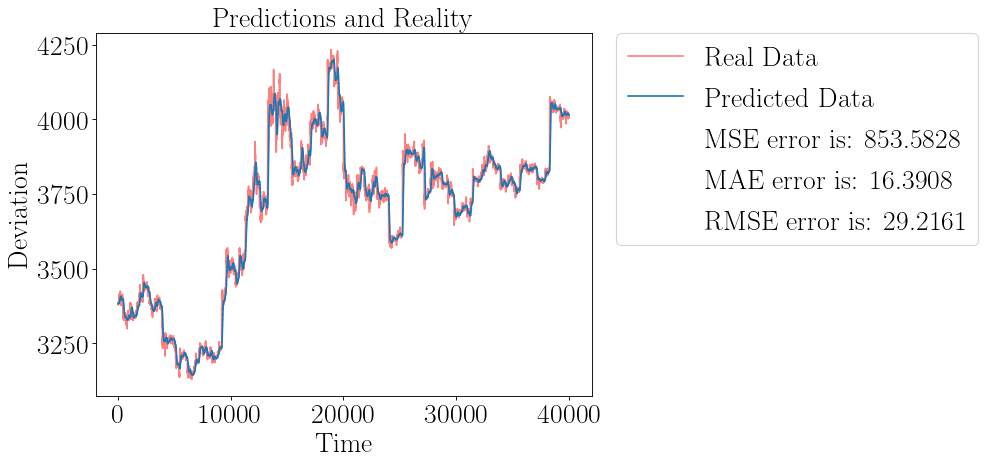

In [3]:
import torch
import numpy as np

# Set a seed for reproductability
seed_value = 42
torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed_value)


naive(INITIAL_DATA = INITIAL_DATA, #We will use data from 48hours of two days
      PRED_DATA = PRED_DATA,       #We will try to predict data for 24hours of the next day
      SPLITTER = SPLITTER,
      BATCH = BATCH)               #Batch size increased from 5 to account for more data avaialbe and for processing times

### LSTM Network Pruning

In [4]:
from thesis_functions_redux import *
%matplotlib inline

def experiment(INITIAL_DATA,
               PRED_DATA,
               SPLITTER,
               BATCH,
               HIDDEN_NN,
               NUM_LAYERS,
               EPOCHS):
    """
                                                Description:
    --------------------------------------------------------------------------------------------------------------
    This is an all bundled functins together function. The concept is to allow for multiple executions of the 
    experimentations, by creating a smaller hyperparameters input window. However, still strongly adivsed to set
    the original values carefully for the functions inside of this function.
    --------------------------------------------------------------------------------------------------------------
    
                                              Input Parameters:
    --------------------------------------------------------------------------------------------------------------    
    > INITIAL_DATA = amount of data you want to use for predicting something;
    > PRED_DATA    = amount of data you want to predict;
    > SPLITTER     = how much data will go into training and how much into testing;
    > BATCH        = how big will be the training batch;
    
    > HIDDEN_NN    = how many hidden neurons are you using;
    > NUM_LAYERS   = how many hidden layers are you using;
    > EPOCHS       = for how many epochs do you want to train the data;
    --------------------------------------------------------------------------------------------------------------
    
                                                   Output:
    --------------------------------------------------------------------------------------------------------------
    > kpi   = will indicate how many units should be created in the next model created and trained;
    > model = will allow to access the model and assess it's size and components after the whole training is done;
    --------------------------------------------------------------------------------------------------------------
    """
    # Prepare the Dummy Data of cos/sin waves
    #---------------------------------------------
    #Temperature dataset will be loaded and visualized, but here it's done manually
    import pandas as pd
    import matplotlib.pyplot as plt
    full_data = pd.read_csv("bitcoin_exp.csv").to_numpy()
    #We will want to save the figure straight away
    f = plt.figure(figsize=(8, 6), dpi=80)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.plot(full_data)
    plt.xlabel("Time in minutes")
    plt.ylabel("BitCoin Deviations")
    plt.title("BitCoin Average Price Fluctuations Per Minute")
    f.savefig("BitCoin_generated.pdf", bbox_inches='tight')
    plt.show()
    plt.close(f)
    
#     REDACTED
#     full_data = wave(instances = INSTANCES,
#                      duration = DURATION,
#                      add_err = ADD_ERR,
#                      wave_type = "sin",
#                      show = True,
#                      save_fig = False)


    #Prepare to either use CPU or GPU
    #---------------------------------------------------------------------------------------------------
    device = gpu_activation("gpu", 
                            confirm = True)

    
    # Scale the data; it is best to do this not via functions
    #--------------------------------------------------------------------------------------------
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    full_data = scaler.fit_transform(full_data.reshape(-1, 1))
    full_data = full_data.reshape(1, -1)[0]
    # full_data = scaler.inverse_transform(full_data) # To turn data back to it's original size

    # Split the data
    #--------------------------------------------------------------------------------------------
    x_training, y_training, x_testing, y_testing = window_slider(data = full_data,
                                                                 initial_data = INITIAL_DATA,
                                                                 pred_data = PRED_DATA,
                                                                 splitter = SPLITTER,
                                                                 prepare_log = True,
                                                                 integrity = True,
                                                                 save_fig = True) 

    
    # Prepare the loaders
    #---------------------------------------------------------------------------------------------------
    train_loader, test_loader = loaders(x_training = x_training,
                                        y_training = y_training,
                                        x_testing = x_testing,
                                        y_testing = y_testing, 
                                        BATCH = BATCH, 
                                        SHUFFLE_TRAIN = True, 
                                        SHUFFLE_TEST = False, 
                                        verify = True)

    # Build a model
    #---------------------------------------------------------------------------------------------------
    model = model_build(hidden_nn = HIDDEN_NN, 
                        data_inputs = INITIAL_DATA, 
                        data_targets = PRED_DATA, 
                        device = device,
                        num_layers = NUM_LAYERS,
                        dropout = 0.0,
                        bias = True,
                        verify = True)

    # For more control the following parameters are seperate:
    import torch
    import torch.nn as nn
    import torch.optim as optim

    CRITERION = nn.MSELoss()
    OPTIMIZER = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Initiate the training
    #---------------------------------------------------------------------------------------------------
    training_init(model = model,
                  train_loader = train_loader,
                  epochs = EPOCHS,
                  data_input = INITIAL_DATA,
                  data_targets = PRED_DATA,
                  device = device,
                  criterion = CRITERION,
                  optimizer = OPTIMIZER,
                  frequency = 4500,
                  verbose = 2)

    # Test Our Model
    #---------------------------------------------------------------------------------------------------
    predictions, reality = testing_init(model = model,
                                        test_loader = test_loader,
                                        input_data = INITIAL_DATA,
                                        device = device)

    # Rescale our data back to what we would want to have
    #---------------------------------------------------------------------------------------------------
    import numpy as np
    FINAL_PREDICTIONS = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).reshape(1, -1)[0]
    FINAL_REALITY     = scaler.inverse_transform(np.array(reality).reshape(-1, 1)).reshape(1, -1)[0]

    # Check the accuracy of our model
    #---------------------------------------------------------------------------------------------------
    accuracy_check(predictions = FINAL_PREDICTIONS,
                   reality = FINAL_REALITY,
                   model = model,
                   mse = True,
                   mae = True,
                   rmse = True,
                   visualize = True,
                   save_fig = True,
                   logger = True,
                   txt_logger = True,
                   baseline = False)

    # Visualize the tensor transformations in the model
    #---------------------------------------------------------------------------------------------------
    see_layers(model,
               visualize = True,
               save_fig = True,
               view_range = True,
               range_values = 200)

    # Analyse the data and give recommendations what can be prunned using k-means method
    #---------------------------------------------------------------------------------------------------
    kpi = nn_analysis(model,
                      visualize = True,
                      save_fig = True,
                      prep_log = True,
                      log_save = True,
                      kpi = True)
    
    return kpi, model

Pass #1 with 32 Neurons.


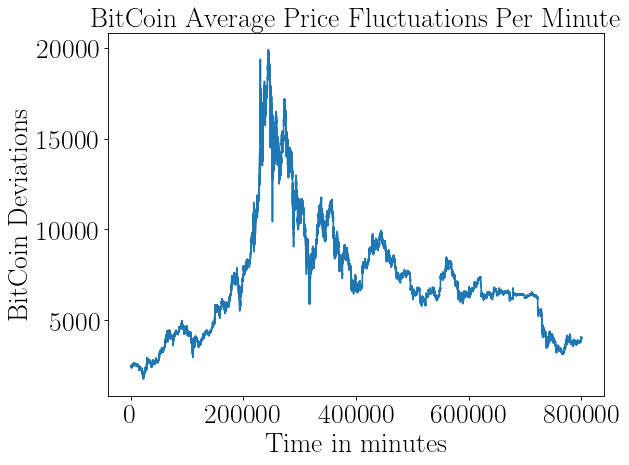

Currently [cuda] was set up for usage
--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(760364, 120)
	Training targets have the following shape: 	(760364, 15)

	Testing data has the following shape: 		(2668, 120)
	Testing targets have the following shape: 	(2668, 15)
----------------------------------------------------------------------


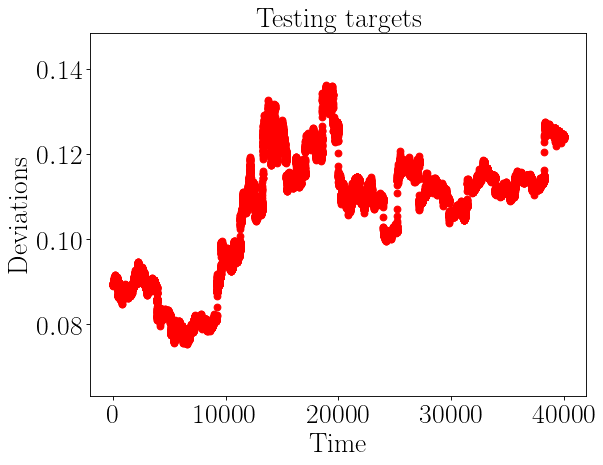

------------------------------------------------LOG-------------------------------------------------------
		Training data has the following shape per batch:	 torch.Size([44, 120])
		Training labels have the following shape per batch:	 torch.Size([44, 15])
		Testing data has the following shape per batch:		 torch.Size([44, 120])
		Testing labels have the following shape per batch:	 torch.Size([44, 15])
-----------------------------------------------------------------------------------------------------------
LSTM_NN(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=3840, out_features=15, bias=True)
)
Training initiated
EPOCH: 1
Epoch [1/8], Step [4500/17281], Loss: 0.0000
Epoch [1/8], Step [9000/17281], Loss: 0.0000
Epoch [1/8], Step [13500/17281], Loss: 0.0000

EPOCH: 2
Epoch [2/8], Step [4500/17281], Loss: 0.0000
Epoch [2/8], Step [9000/17281], Loss: 0.0000
Epoch [2/8], Step [13500/17281], Loss: 0.0000

EPOCH: 3
Epoch [3/8], Step [4500/17281], Loss: 0.0000
Epoch [3/

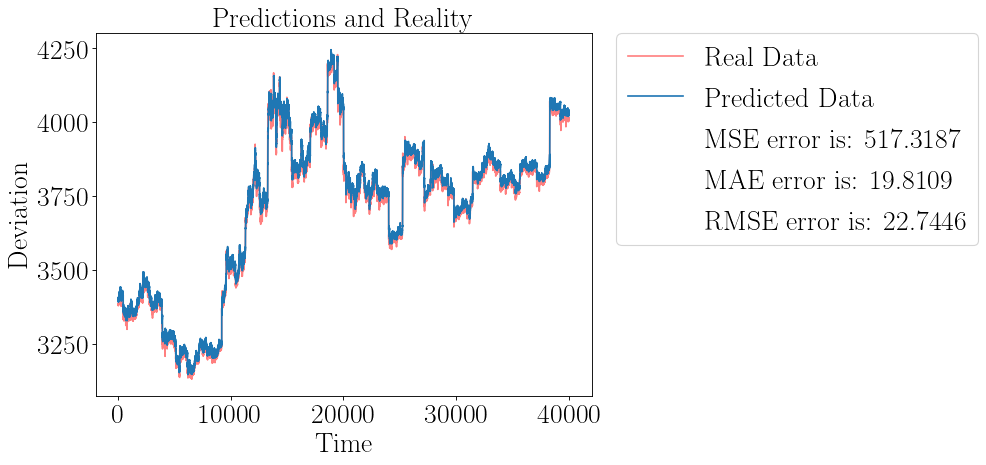

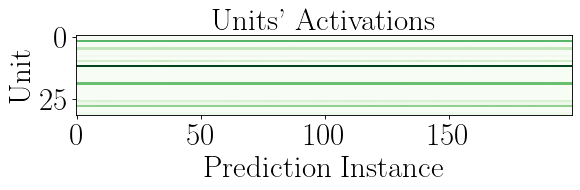

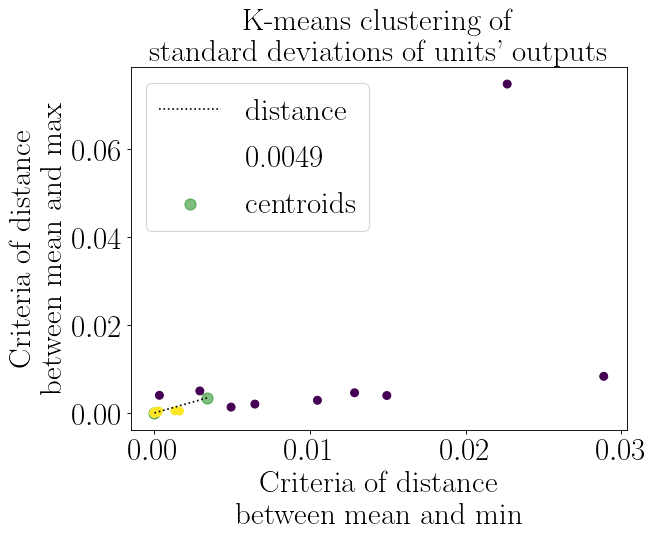

----------------------LOG--------------------------

> 9 neurons in class 0 
> 23 neurons in class 1.

Nueron#		Class		    Coordinates
   1 		  1 		[X: 0.0, Y: 0.0].
   2 		  1 		[X: 0.0, Y: 0.0].
   3 		  0 		[X: 0.015, Y: 0.004].
   4 		  1 		[X: 0.0, Y: 0.0].
   5 		  0 		[X: 0.0, Y: 0.004].
   6 		  0 		[X: 0.006, Y: 0.002].
   7 		  1 		[X: 0.0, Y: 0.0].
   8 		  1 		[X: 0.0, Y: 0.0].
   9 		  1 		[X: 0.001, Y: 0.001].
   10 		  1 		[X: 0.0, Y: 0.0].
   11 		  0 		[X: 0.023, Y: 0.075].
   12 		  1 		[X: 0.0, Y: 0.0].
   13 		  0 		[X: 0.029, Y: 0.008].
   14 		  1 		[X: 0.0, Y: 0.0].
   15 		  1 		[X: 0.0, Y: 0.0].
   16 		  1 		[X: 0.0, Y: 0.0].
   17 		  1 		[X: 0.0, Y: 0.0].
   18 		  1 		[X: 0.0, Y: 0.0].
   19 		  1 		[X: 0.0, Y: 0.0].
   20 		  0 		[X: 0.013, Y: 0.005].
   21 		  1 		[X: 0.0, Y: 0.0].
   22 		  1 		[X: 0.0, Y: 0.0].
   23 		  1 		[X: 0.0, Y: 0.0].
   24 		  1 		[X: 0.0, Y: 0.0].
   25 		  1 		[X: 0.0, Y: 0.0].
   26 		  1 		[X: 0.0, Y: 0.0].
   27 		  0 		[X

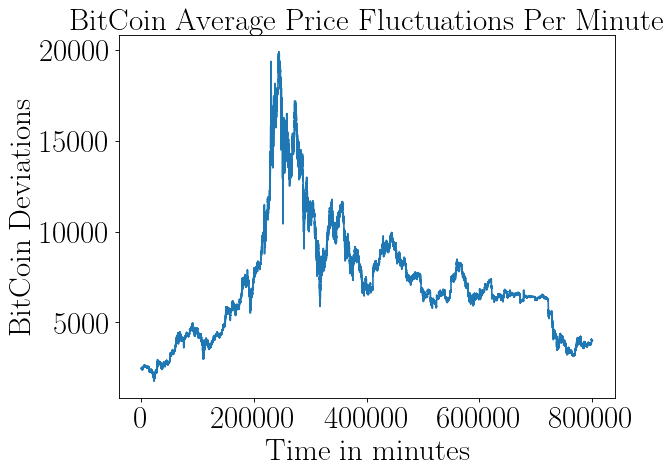

Currently [cuda] was set up for usage
--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(760364, 120)
	Training targets have the following shape: 	(760364, 15)

	Testing data has the following shape: 		(2668, 120)
	Testing targets have the following shape: 	(2668, 15)
----------------------------------------------------------------------


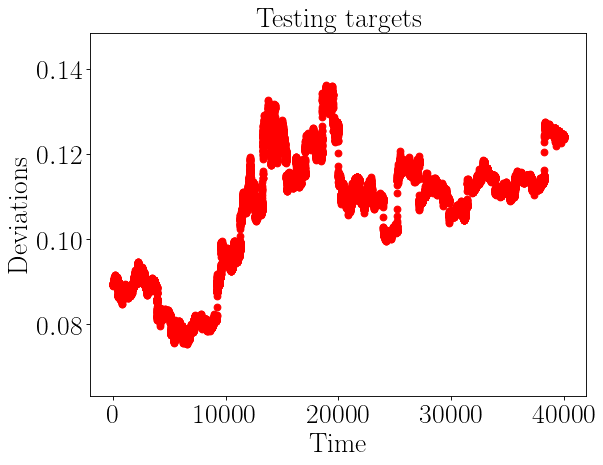

------------------------------------------------LOG-------------------------------------------------------
		Training data has the following shape per batch:	 torch.Size([44, 120])
		Training labels have the following shape per batch:	 torch.Size([44, 15])
		Testing data has the following shape per batch:		 torch.Size([44, 120])
		Testing labels have the following shape per batch:	 torch.Size([44, 15])
-----------------------------------------------------------------------------------------------------------
LSTM_NN(
  (lstm): LSTM(1, 9, batch_first=True)
  (fc): Linear(in_features=1080, out_features=15, bias=True)
)
Training initiated
EPOCH: 1
Epoch [1/8], Step [4500/17281], Loss: 0.0000
Epoch [1/8], Step [9000/17281], Loss: 0.0000
Epoch [1/8], Step [13500/17281], Loss: 0.0000

EPOCH: 2
Epoch [2/8], Step [4500/17281], Loss: 0.0000
Epoch [2/8], Step [9000/17281], Loss: 0.0000
Epoch [2/8], Step [13500/17281], Loss: 0.0000

EPOCH: 3
Epoch [3/8], Step [4500/17281], Loss: 0.0000
Epoch [3/8

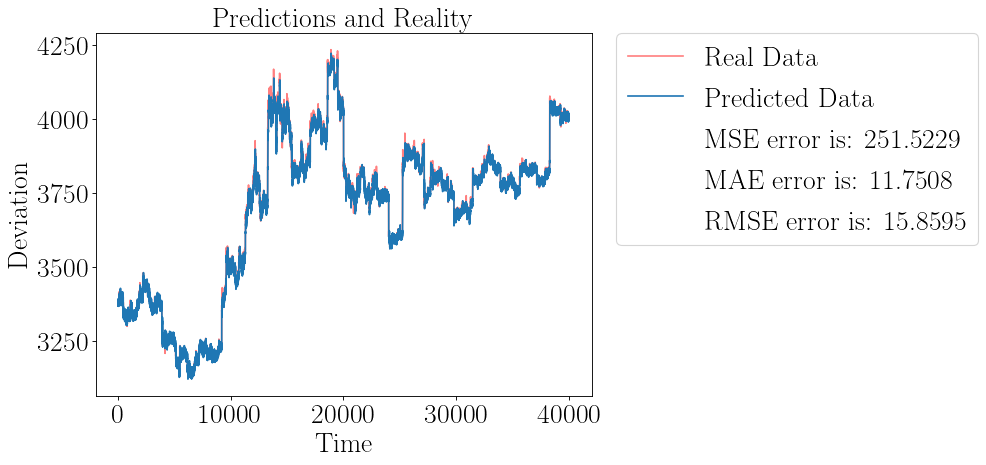

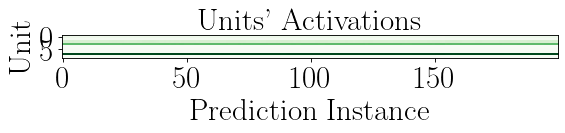

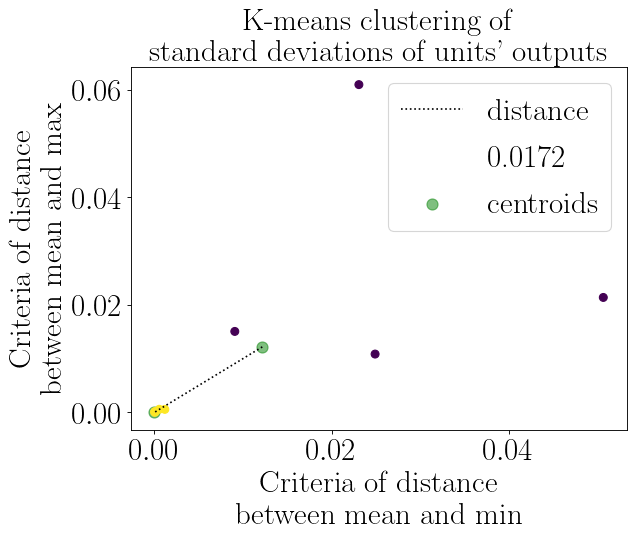

----------------------LOG--------------------------

> 4 neurons in class 0 
> 5 neurons in class 1.

Nueron#		Class		    Coordinates
   1 		  0 		[X: 0.009, Y: 0.015].
   2 		  1 		[X: 0.001, Y: 0.001].
   3 		  0 		[X: 0.023, Y: 0.061].
   4 		  0 		[X: 0.025, Y: 0.011].
   5 		  1 		[X: 0.0, Y: 0.0].
   6 		  1 		[X: 0.001, Y: 0.001].
   7 		  1 		[X: 0.0, Y: 0.0].
   8 		  0 		[X: 0.051, Y: 0.021].
   9 		  1 		[X: 0.0, Y: 0.0].

---------------------------------------------------
Pass #3 with 4 Neurons.


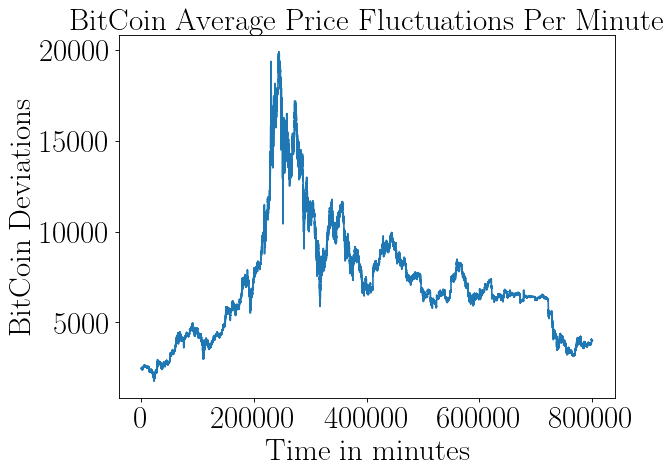

Currently [cuda] was set up for usage
--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(760364, 120)
	Training targets have the following shape: 	(760364, 15)

	Testing data has the following shape: 		(2668, 120)
	Testing targets have the following shape: 	(2668, 15)
----------------------------------------------------------------------


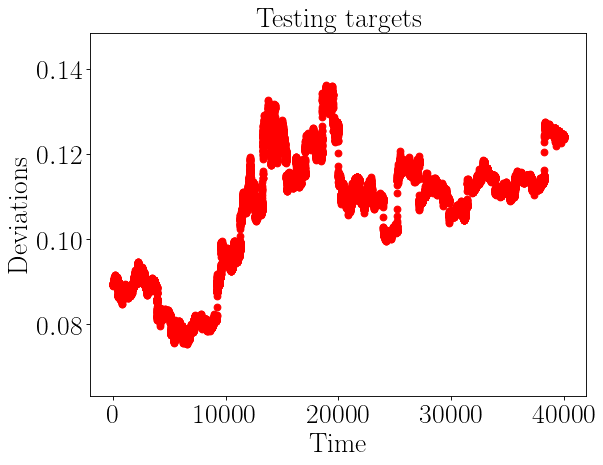

------------------------------------------------LOG-------------------------------------------------------
		Training data has the following shape per batch:	 torch.Size([44, 120])
		Training labels have the following shape per batch:	 torch.Size([44, 15])
		Testing data has the following shape per batch:		 torch.Size([44, 120])
		Testing labels have the following shape per batch:	 torch.Size([44, 15])
-----------------------------------------------------------------------------------------------------------
LSTM_NN(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=480, out_features=15, bias=True)
)
Training initiated
EPOCH: 1
Epoch [1/8], Step [4500/17281], Loss: 0.0000
Epoch [1/8], Step [9000/17281], Loss: 0.0000
Epoch [1/8], Step [13500/17281], Loss: 0.0000

EPOCH: 2
Epoch [2/8], Step [4500/17281], Loss: 0.0000
Epoch [2/8], Step [9000/17281], Loss: 0.0000
Epoch [2/8], Step [13500/17281], Loss: 0.0000

EPOCH: 3
Epoch [3/8], Step [4500/17281], Loss: 0.0000
Epoch [3/8]

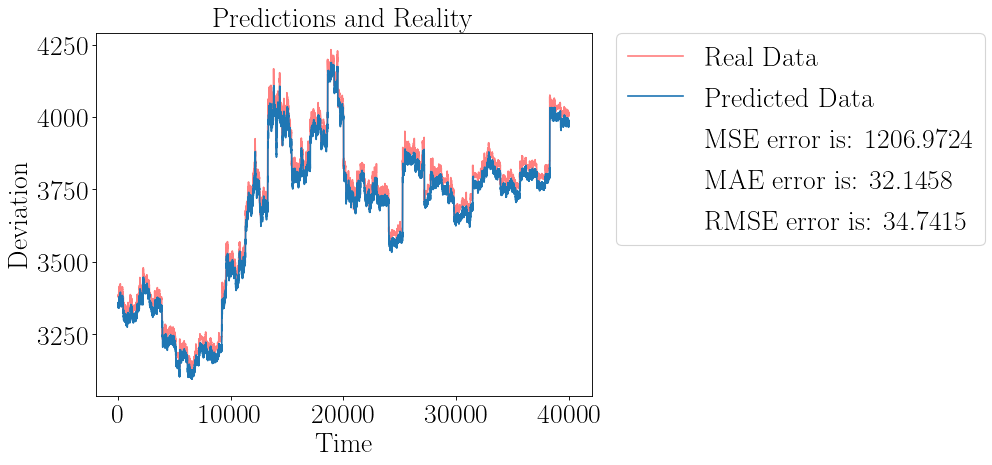

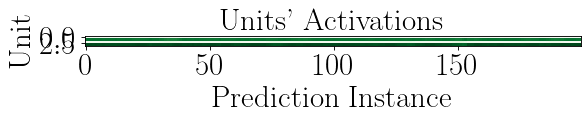

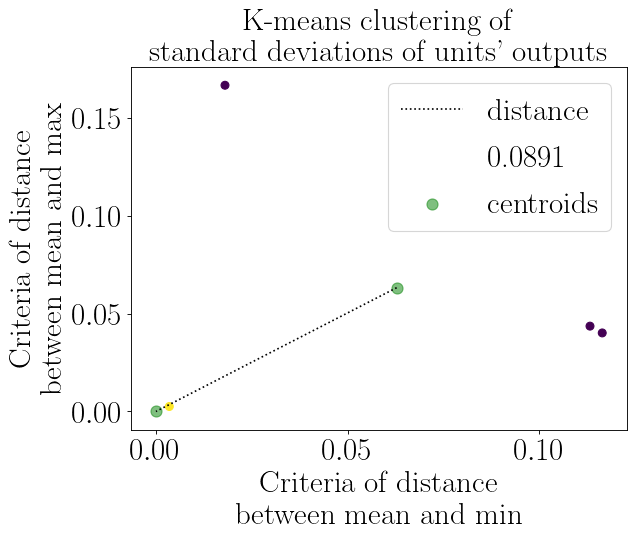

----------------------LOG--------------------------

> 3 neurons in class 0 
> 1 neurons in class 1.

Nueron#		Class		    Coordinates
   1 		  1 		[X: 0.003, Y: 0.003].
   2 		  0 		[X: 0.113, Y: 0.044].
   3 		  0 		[X: 0.018, Y: 0.167].
   4 		  0 		[X: 0.116, Y: 0.04].

---------------------------------------------------
Pass #4 with 3 Neurons.


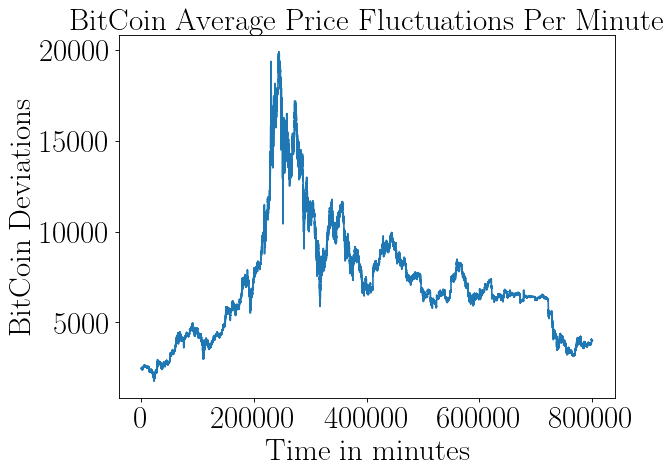

Currently [cuda] was set up for usage
--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(760364, 120)
	Training targets have the following shape: 	(760364, 15)

	Testing data has the following shape: 		(2668, 120)
	Testing targets have the following shape: 	(2668, 15)
----------------------------------------------------------------------


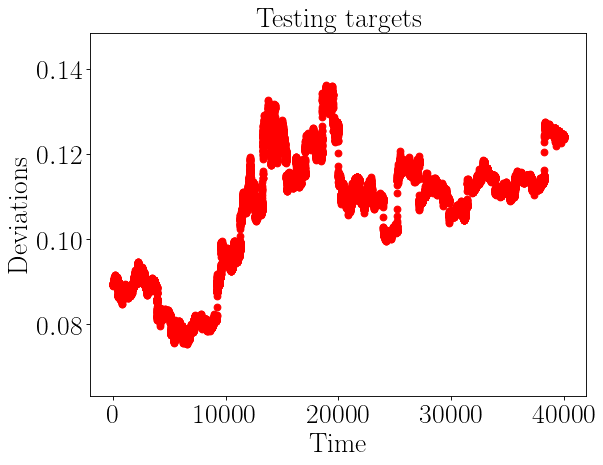

------------------------------------------------LOG-------------------------------------------------------
		Training data has the following shape per batch:	 torch.Size([44, 120])
		Training labels have the following shape per batch:	 torch.Size([44, 15])
		Testing data has the following shape per batch:		 torch.Size([44, 120])
		Testing labels have the following shape per batch:	 torch.Size([44, 15])
-----------------------------------------------------------------------------------------------------------
LSTM_NN(
  (lstm): LSTM(1, 3, batch_first=True)
  (fc): Linear(in_features=360, out_features=15, bias=True)
)
Training initiated
EPOCH: 1
Epoch [1/8], Step [4500/17281], Loss: 0.0000
Epoch [1/8], Step [9000/17281], Loss: 0.0000
Epoch [1/8], Step [13500/17281], Loss: 0.0000

EPOCH: 2
Epoch [2/8], Step [4500/17281], Loss: 0.0000
Epoch [2/8], Step [9000/17281], Loss: 0.0000
Epoch [2/8], Step [13500/17281], Loss: 0.0000

EPOCH: 3
Epoch [3/8], Step [4500/17281], Loss: 0.0000
Epoch [3/8]

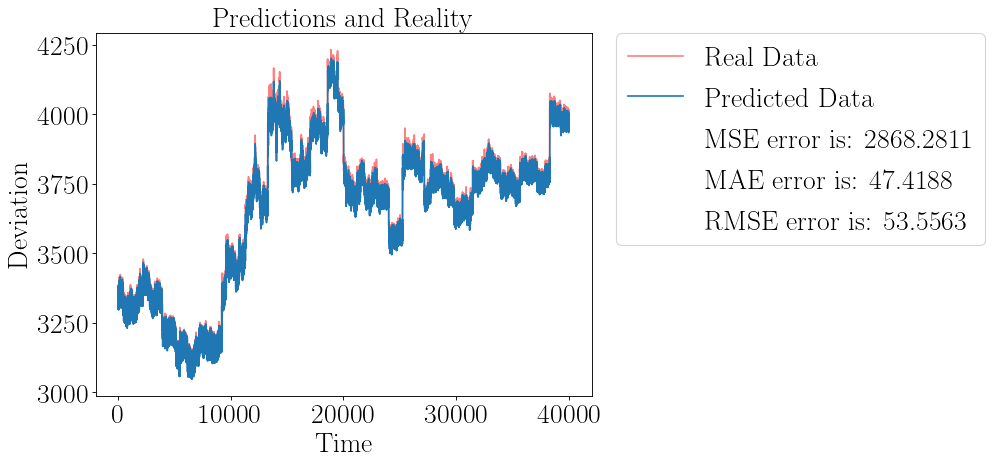

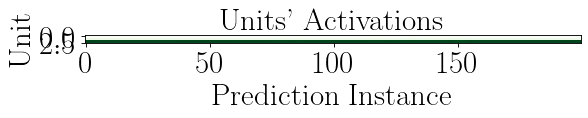

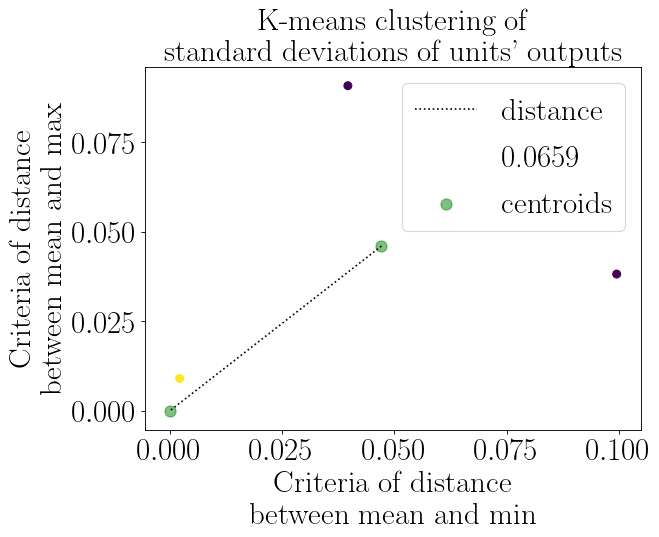

----------------------LOG--------------------------

> 2 neurons in class 0 
> 1 neurons in class 1.

Nueron#		Class		    Coordinates
   1 		  1 		[X: 0.002, Y: 0.009].
   2 		  0 		[X: 0.04, Y: 0.091].
   3 		  0 		[X: 0.099, Y: 0.038].

---------------------------------------------------
Pass #5 with 2 Neurons.


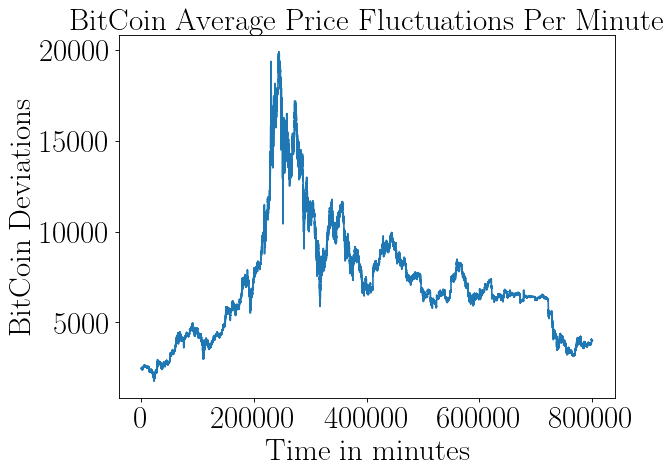

Currently [cuda] was set up for usage
--------------------------------LOG-----------------------------------
	Training data has the following shape: 		(760364, 120)
	Training targets have the following shape: 	(760364, 15)

	Testing data has the following shape: 		(2668, 120)
	Testing targets have the following shape: 	(2668, 15)
----------------------------------------------------------------------


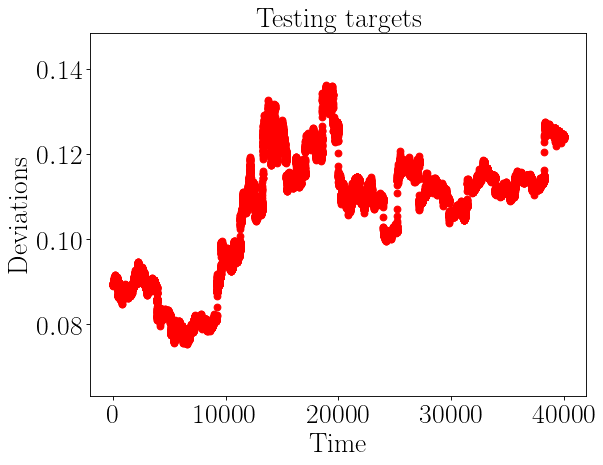

------------------------------------------------LOG-------------------------------------------------------
		Training data has the following shape per batch:	 torch.Size([44, 120])
		Training labels have the following shape per batch:	 torch.Size([44, 15])
		Testing data has the following shape per batch:		 torch.Size([44, 120])
		Testing labels have the following shape per batch:	 torch.Size([44, 15])
-----------------------------------------------------------------------------------------------------------
LSTM_NN(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=240, out_features=15, bias=True)
)
Training initiated
EPOCH: 1
Epoch [1/8], Step [4500/17281], Loss: 0.0000
Epoch [1/8], Step [9000/17281], Loss: 0.0000
Epoch [1/8], Step [13500/17281], Loss: 0.0000

EPOCH: 2
Epoch [2/8], Step [4500/17281], Loss: 0.0000
Epoch [2/8], Step [9000/17281], Loss: 0.0000
Epoch [2/8], Step [13500/17281], Loss: 0.0000

EPOCH: 3
Epoch [3/8], Step [4500/17281], Loss: 0.0000
Epoch [3/8]

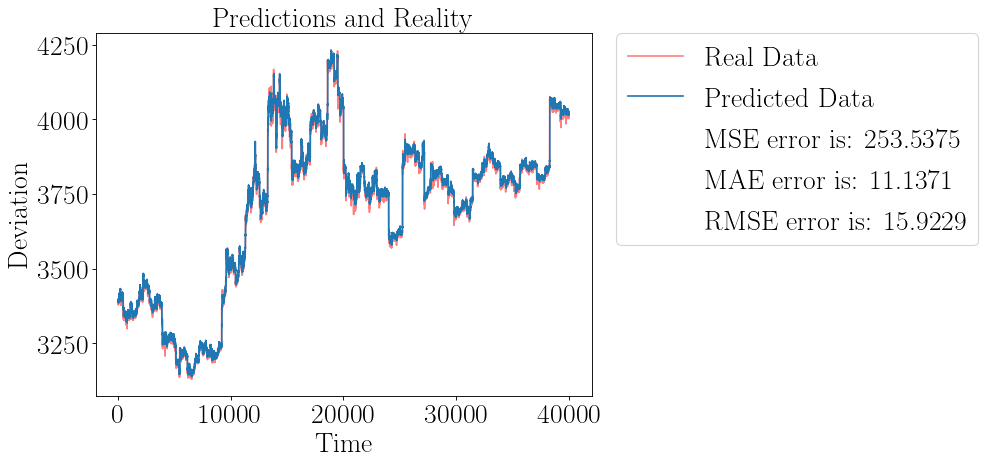

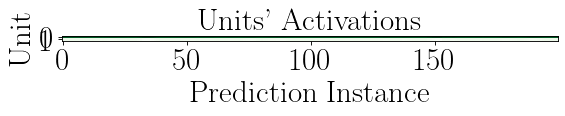

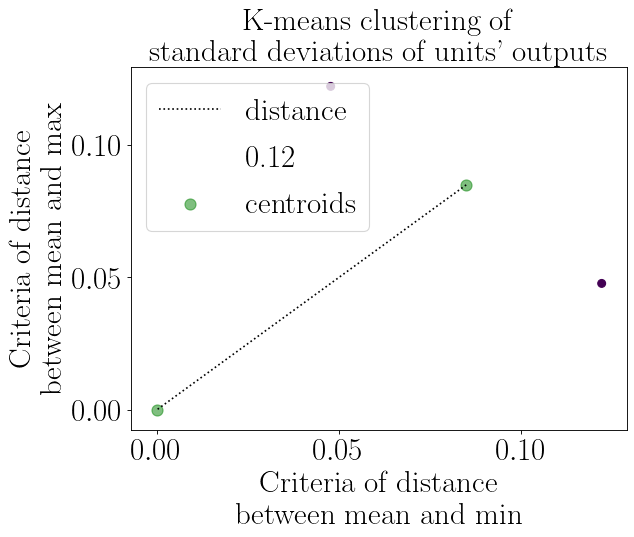

----------------------LOG--------------------------

> 2 neurons in class 0 
> 0 neurons in class 1.

Nueron#		Class		    Coordinates
   1 		  0 		[X: 0.048, Y: 0.122].
   2 		  0 		[X: 0.122, Y: 0.048].

---------------------------------------------------
Pass #6 with 2 Neurons.
Itterations are being stopped!


In [5]:
import torch
import numpy as np
seed_value = 42 #KEEP THIS

kpi = 32    # Start off with 256 units in the network (reduced to 64 as other models seemed to not use as many units as 256)
prev_kpi = 0 # We also need a memory based variable that keep track of what the previous kpi indicator was
             # We do not want them to match in the beginning therefore we assign a 0 from the start

for i in range(20): # We want our model to stop in case it takes longer than 20 itteration steps
    print("Pass #{} with {} Neurons.".format(i + 1, kpi))
    if kpi == prev_kpi:
        print("Itterations are being stopped!")
        break
    else:
        prev_kpi = kpi
        # Set a seed for reproductability
        torch.manual_seed(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed_value)

        # The value of kpi will be feeding back into itself on each pass
        kpi, model = experiment(INITIAL_DATA = INITIAL_DATA,
                                PRED_DATA = PRED_DATA,
                                SPLITTER = SPLITTER,
                                BATCH = BATCH,
                                HIDDEN_NN = kpi,
                                NUM_LAYERS = 1, # We need only 1 LSTM layer
                                EPOCHS = 8)    # Each prined iteration will train for 14 epochs

### Performance of the Model, pruned with the Researched Methodology, compared to the Naïve Baseline

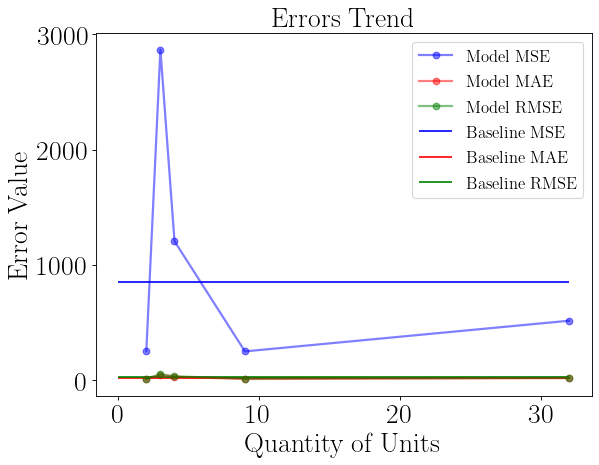

In [6]:
def errors_view(neur_max,
                save_fig = False,
                file = "errors_analysis.txt"):
    """
                                            Description:
    ------------------------------------------------------------------------------------------------
    Visualize the series of errors that happen with different stages of changing the amount of neurons
    that the network works with.
    ------------------------------------------------------------------------------------------------

                                              Input:
    ------------------------------------------------------------------------------------------------
    > save_fig = indicate whether you want to save the figure produced. DEFAULT: False
    > file     = indicate the name of the file from which to read the data. DEFAULT: errors_analysis.txt
    > neur_max = amount of neurons experimented with.
    ------------------------------------------------------------------------------------------------

                                              Output:
    ------------------------------------------------------------------------------------------------
    > None = produces a plot for a visual assessment only
    ------------------------------------------------------------------------------------------------

    """

    # Import needed packages
    import matplotlib.pyplot as plt
    import pandas as pd

    df = pd.read_csv(file,
                     sep = ",")
    df_graph = df[df["baseline"] == False] 
    df_baseline = df[df["baseline"] == True]
    
    y_mse  = list(dict.fromkeys(df_baseline["MSE"]))
    y_mae  = list(dict.fromkeys(df_baseline["MAE"]))
    y_rmse = list(dict.fromkeys(df_baseline["RMSE"]))

    f = plt.figure(figsize=(8, 6), dpi=80)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    #Adjustments to the font
    MEDIUM_SIZE = 25
    plt.rc('font', size = MEDIUM_SIZE)      
    plt.rc('axes', titlesize = MEDIUM_SIZE)     
    plt.rc('axes', labelsize = MEDIUM_SIZE)    
    plt.rc('xtick', labelsize = MEDIUM_SIZE)    
    plt.rc('ytick', labelsize = MEDIUM_SIZE)    
    plt.rc('legend', fontsize = 15)    
    plt.rc('figure', titlesize = MEDIUM_SIZE)
    
    # Evaluate data points
    plt.plot(df_graph["Neurons"], df_graph["MSE"], "bo-", label = "Model MSE", linewidth = 2, alpha = 0.5)
    plt.plot(df_graph["Neurons"], df_graph["MAE"], "ro-", label = "Model MAE", linewidth = 2, alpha = 0.5)
    plt.plot(df_graph["Neurons"], df_graph["RMSE"], "go-", label = "Model RMSE", linewidth = 2, alpha = 0.5)
    
    # Baseline...lines
    plt.hlines(y = y_mse, xmin = 0, xmax = neur_max, colors='b', linestyles='solid', label='Baseline MSE')
    plt.hlines(y = y_mae, xmin = 0, xmax = neur_max, colors='r', linestyles='solid', label='Baseline MAE')
    plt.hlines(y =y_rmse, xmin = 0, xmax = neur_max, colors='g', linestyles='solid', label='Baseline RMSE')
    
    plt.legend(loc = "best")
    plt.title("Errors Trend", fontsize=MEDIUM_SIZE)
    plt.xlabel("Quantity of Units", fontsize=MEDIUM_SIZE)
    plt.ylabel("Error Value", fontsize=MEDIUM_SIZE)
    plt.show()

    if save_fig == True:
        fname = str("Errors over Units variations.pdf")
        f.savefig(fname, bbox_inches='tight')


errors_view(neur_max = 32,
            save_fig = True,
            file = "errors_analysis.txt")

## And one with the log

In [8]:
def errors_view_log(neur_max,
                    save_fig = False,
                    file = "errors_analysis.txt"):
    """
                                            Description:
    ------------------------------------------------------------------------------------------------
    Visualize the series of errors that happen with different stages of changing the amount of neurons
    that the network works with. This converts yscale to log (not linear).
    ------------------------------------------------------------------------------------------------

                                              Input:
    ------------------------------------------------------------------------------------------------
    > save_fig = indicate whether you want to save the figure produced. DEFAULT: False
    > file     = indicate the name of the file from which to read the data. DEFAULT: errors_analysis.txt
    > neur_max = amount of neurons experimented with.
    ------------------------------------------------------------------------------------------------

                                              Output:
    ------------------------------------------------------------------------------------------------
    > None = produces a plot for a visual assessment only
    ------------------------------------------------------------------------------------------------

    """

    # Import needed packages
    import matplotlib.pyplot as plt
    import pandas as pd

    df = pd.read_csv(file,
                     sep = ",")
    df_graph = df[df["baseline"] == False] 
    df_baseline = df[df["baseline"] == True]
    
    y_mse  = list(dict.fromkeys(df_baseline["MSE"]))
    y_mae  = list(dict.fromkeys(df_baseline["MAE"]))
    y_rmse = list(dict.fromkeys(df_baseline["RMSE"]))

    f = plt.figure(figsize=(8, 6), dpi=80)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    #Adjustments to the font
    MEDIUM_SIZE = 25
    plt.rc('font', size = MEDIUM_SIZE)      
    plt.rc('axes', titlesize = MEDIUM_SIZE)     
    plt.rc('axes', labelsize = MEDIUM_SIZE)    
    plt.rc('xtick', labelsize = MEDIUM_SIZE)    
    plt.rc('ytick', labelsize = MEDIUM_SIZE)    
    plt.rc('legend', fontsize = 15)    
    plt.rc('figure', titlesize = MEDIUM_SIZE)
    
    # Evaluate data points
    plt.plot(df_graph["Neurons"], df_graph["MSE"], "bo-", label = "Model MSE", linewidth = 2, alpha = 0.5)
    plt.plot(df_graph["Neurons"], df_graph["MAE"], "ro-", label = "Model MAE", linewidth = 2, alpha = 0.5)
    plt.plot(df_graph["Neurons"], df_graph["RMSE"], "go-", label = "Model RMSE", linewidth = 2, alpha = 0.5)
    
    # Baseline...lines
    plt.hlines(y = y_mse, xmin = 0, xmax = neur_max, colors='b', linestyles='solid', label='Baseline MSE')
    plt.hlines(y = y_mae, xmin = 0, xmax = neur_max, colors='r', linestyles='solid', label='Baseline MAE')
    plt.hlines(y =y_rmse, xmin = 0, xmax = neur_max, colors='g', linestyles='solid', label='Baseline RMSE')
    
    # Set the y scale to log
    plt.yscale("log", basey=2)
    
    plt.legend(loc = "upper right")
    plt.title("Errors Trend", fontsize=MEDIUM_SIZE)
    plt.xlabel("Quantity of Units", fontsize=MEDIUM_SIZE)
    plt.ylabel("Error Value (log)", fontsize=MEDIUM_SIZE)
    plt.show()

    if save_fig == True:
        fname = str("Errors over Units variations.pdf")
        f.savefig(fname, bbox_inches='tight')

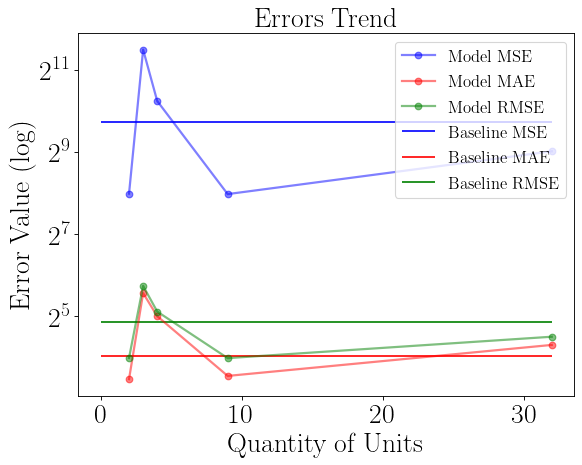

In [9]:
errors_view_log(neur_max = 32,
                save_fig = True,
                file = "errors_analysis.txt")

### Comparing the storage size

In [7]:
device = gpu_activation("gpu", confirm = False)

pruned_model   = model                             # NN Prepared
original_model = model_build(hidden_nn = 32,      # Initial NN
                             data_inputs = INITIAL_DATA, 
                             data_targets = PRED_DATA, 
                             device = device,
                             num_layers = 1,
                             dropout = 0.0,
                             bias = True,
                             verify = False)

In [8]:
#Save prunned model as is
torch.save(pruned_model.state_dict(), "Pruned_Model_Bit.pt")

#Save original model as is
torch.save(original_model.state_dict(), "Original_Model_Bit.pt")

In [9]:
import numpy as np
from scipy.sparse import csc_matrix
#Save prunned model's weight values (connections) that lay between the lstm and fc layers
#If there is any sparsity, we account for it before saving
#Sparse format will be re-used when saving the models for the SOTA baseline

#We need a zeros matrix that is equal in shape to our weights matrix
zeros_M = np.zeros(len(pruned_model.fc.weight.data.flatten())).reshape(np.array(pruned_model.fc.weight.data.cpu().numpy()).shape[0], 
                                                                        np.array(pruned_model.fc.weight.data.cpu().numpy()).shape[1])

pruned_model_WM = pruned_model.fc.weight.data.cpu().numpy() #WM - weight matrix
pruned_model_WM[np.isclose(pruned_model.fc.weight.data.cpu().numpy(),zeros_M)] = 0
pruned_model_WM = csc_matrix(pruned_model_WM)
np.save(file = "Pruned_Sparse_Bit_Weights.npy", arr = pruned_model_WM)

#Save orignal model's weight values (connections) that lay between the lstm and fc layers
#If there is any sparsity, we account for it before saving

#We need a zeros matrix that is equal in shape to our weights matrix
zeros_M = np.zeros(len(original_model.fc.weight.data.flatten())).reshape(np.array(original_model.fc.weight.data.cpu().numpy()).shape[0], 
                                                                         np.array(original_model.fc.weight.data.cpu().numpy()).shape[1])

original_model_WM = original_model.fc.weight.data.cpu().numpy() #WM - weight matrix
original_model_WM[np.isclose(original_model.fc.weight.data.cpu().numpy(),zeros_M)] = 0
original_model_WM = csc_matrix(original_model_WM)
np.save(file = "Original_Sparse_Bit_Weights.npy", arr = original_model_WM)

In [10]:
#Now to compare the final sizes (information is in bytes)
import os

#For models saved as is
pruned_full  = os.path.getsize("Pruned_Model_Bit.pt")
orginal_full = os.path.getsize("Original_Model_Bit.pt")

# For sparse weights saved between lstm and fc layers
pruned_sparse_red   = os.path.getsize("Pruned_Sparse_Bit_Weights.npy")
original_sparse_red = os.path.getsize("Original_Sparse_Bit_Weights.npy")

print("Size of the Pruned model is: \t\t\t{} bytes".format(pruned_full))
print("Size of the Original model is: \t\t\t{} bytes".format(orginal_full))
print("Size of the Pruned lstm-fc weights is: \t\t{} bytes".format(pruned_sparse_red))
print("Size of the Original lstm-fc weights is: \t{} bytes".format(original_sparse_red))

print("----------------------------------------------------------------------------------------------")
print("\tThe pruned model as is, is x{} times smaller than the original model size.".format(np.round(orginal_full/pruned_full, 2)))
print("   The pruned weights model , is x{} times smaller than the original weights model size.".format(np.round(original_sparse_red/pruned_sparse_red, 2)))
print("----------------------------------------------------------------------------------------------")

Size of the Pruned model is: 			30236 bytes
Size of the Original model is: 			497764 bytes
Size of the Pruned lstm-fc weights is: 		60661 bytes
Size of the Original lstm-fc weights is: 	849512 bytes
----------------------------------------------------------------------------------------------
	The pruned model as is, is x16.46 times smaller than the original model size.
   The pruned weights model , is x14.0 times smaller than the original weights model size.
----------------------------------------------------------------------------------------------


In [11]:
pruned_amount = np.array(pruned_model.fc.weight.data.cpu().numpy()).shape[0] * np.array(pruned_model.fc.weight.data.cpu().numpy()).shape[1]
original_amount = np.array(original_model.fc.weight.data.cpu().numpy()).shape[0] * np.array(original_model.fc.weight.data.cpu().numpy()).shape[1]

print("Pruned Network has {} connections remaining between LSTM and FC layes".format(pruned_amount))
print("Not Pruned Network has {} connections remaining between LSTM and FC layes".format(original_amount))
print("This means amount of weights was reduced by: {}%".format(np.round(100*(original_amount - pruned_amount)/original_amount, 4)))

Pruned Network has 3600 connections remaining between LSTM and FC layes
Not Pruned Network has 57600 connections remaining between LSTM and FC layes
This means amount of weights was reduced by: 93.75%
